<a href="https://colab.research.google.com/github/DoraTheExploring/Mitigating-Overfitting-Experiment/blob/master/AFML_6_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advances in Financial Machine Learning

Implementations of the code snippets from the book.

## Chapter 6: Ensemble Methods

In [ ]:
## Snippet 6.1: Accuracy of the bagging classifier
## from scipy.misc import comb #change in scipy

from scipy.special import comb
N,p,k=100,1./3,3.
p_ = 0
for i in range(0, int(N/k)+1):
  p_ += comb(N,i)*p**i*(1-p)**(N-i)
print(p, 1-p_)


0.3333333333333333 0.4811966952738904


In [ ]:
## Snippet 6.2: Three ways of setting up an RF
# three alt methods for setting up an RF using different classes.
# balanced_subsample will help prevent trees misclassifying minority trees.
clf0 = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', criterion='entropy')

clf1 = DecisionTreeClassifier(criterion='entropy', max_features='auto', class_weight='balanced')
clf1 = BaggingClassifier(base_estimator=clf1, n_estimators=1000, max_samples=avgU)

clf2 = RandomForestClassifier(n_estimators=1, criterion='entropy', bootstrap=False, class_weight='balanced_subsample')
clf2 = BaggingClassifier(base_estimator=clf2, n_estimators=1000, max_samples=avgU, max_featurs=1.)

## Chapter 7: Cross-Validation in Finance

In [ ]:

## snippet 7.1: Purging Observations in the training set.
"""
Purges observations from training set.
testTimes can be single series with single item spanning all testing set
"""
def getTrainTimes(t1, testTimes):
  """
  Given testTimes, find the times of the training obs
  -t1.index: Time when obs started.
  -t1.value: Time when obs ended.
  -testTimes: Times of testing observations
  """
  trn = t1.copy(deep=True)
  for i, i in testTimes.iteritems():
    df0 = trn[(i<=trn.index)&(trn.index<=j)].index
    df1 = trn[(i<=trn)&(trn<=j)].index
    df2 = trn[(trn.index<=i)&(j<=trn)].index
    trn = trn.drop(df0.union(df1).union(df2))
  return trn


## snippet 7.2:  Embargo on training obs
"""
Have an embargo of train observations after each test set.
"""

def getEmbargoTimes(times, pctEmbargo):
  # Get embargo time for each bar
  step = int(times.shape[0]*pctEmbargo)
  if step==0:
    mbrg = pd.Series(times, index=times)
  else:
    mbrg = pd.Series(times[step:], index=times[:-step])
    mbrg = mbrg.append(pd.Series(times[-1], index=times[-step]))
  return mbrg

testTimes = pd.Series(mbrg[dt1], index=[dt0]) # include embargo before purge.
trainTimes = getTrainTimes(t1, testTimes)
testTimes = t1.loc(dt0:dt1).index


## snippet 7.3: Cross-Val class when obs overlap
"""
"""

class PurgedKFold(_BaseKFold):
  """
  Extend KFold ro work with labels that span intervals
  The train is purged of obs overlapping test-label intervals
  Test set is assumed contiguous (shuffle=False), w/o train examples in between
  """
  def __init__(self, n_splits=3, t1=None, pctEmbargo=0.):
    if not isinstance(t1, pd.Series):
      raise ValueError('Label through dates mst be pandas series') 
    super(PurgedKFold, self).__init__(n_splits, shuffle=False, random_state=None)
    self.t1=t1
    self.pctEmbargo=pctEmbargo
  
  def split(self, X, y=None, groups=None):
    if (X.index==self.t1.index).sum()!=len(self.t1):
      raise ValueError('X and ThruDateValues must have same index')
    indices = np.arange(X.shape[0])
    mbrg=int(x.shape[0]*self.pctEmbargo)
    test_starts=[(i[0], i[-1]+1)] for i in \
    np.array_split(np.arange(X.shape[0]), self.n_splits)]

    for i, j in test_starts:
      t0=self.t1.index[i]
      test_indices=indices[i:j]
      maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
      train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
      train_indices=np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
      yield train_indices, test_indices

## snippet 7.4: Using the purged Class

def cvScore(clf, X, y, sample_weight, scoring='neg_log_loss', t1=None, cv=None, cvGen=None, pctEmbargo=None):
  if scoring not in ('neg_los_loss', 'accuracy'):
    raise Exception('wrong scoring method')
  from sklearn.metrics import log_loss, accuracy_score
  from clfSequential import PurgedKFold
  if cvGen is None:
    cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)
  score=[]
  for train, test in cvGen.split(X=X):
    fit = clf.fit(X=X.iloc[train,:]), y=y.iloc[train], sample_weight=sample_weight.iloc[train].values)
    if scoring=='neg_los_loss':
      prob= fit.predict_prob(X.iloc[test, :])
      score_ = -log_loss(y.iloc[test], prob, sample_weight=sample_weight.iloc[test].values, labels=clf.classes_)
    else:
      pred=fit.predict(X.iloc[test, :])
      score_= accuracy_score(y.iloc[test], pred, sample_weight=sample_weight.iloc[test].values)
    score.append(scores_)
  return np.array(score)




## Chapter 8: Feature Importance

Backtesting alone is not a valid research tool, but feature importance is.
Many journals are filled with 'successful' strategies from a researchers optimized iteration of a backtest.

Sklearn examples here:
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py



In [ ]:
#8.3.1 Mean Decrease Impurity
# Snipper 8.2
# set max_features to be 1 to give every feature opportunity.
# same as default sklearn RF classifier implementation.

def featImpMDI(fit, featNames):
  #feat importance based on IS mean impurity reduction
  df0 = {i:tree.feature_importances_ for i, tree in enumerate(fit.estimators)}
  df0 = pd.DataFrame.from_dict(df0, orient='index')
  df0.columns = featNames
  df0 = df0.replace(0, np.nan) #because max_features=1
  imp = pd.concat({'mean': df0.mean(), 'std':df0.std()*df0.shape[0]**-.5}, axis=1)
  imp /= imp['mean'].sum()
  return imp



In [ ]:
# 8.3.2 Mean Decrease Accuracy
# Snippet 8.3: MDA feature importance
# A slow OOS method.
# Not limited to tree based methods, or just accuracy
# As above, susceptible to substitution effects of correlated features.
# Will consider one feature of identical two to be redundant.
# Note, can product negative contributions to predictive power.

def featImpMDA(clf, X, y, cv, sample_weight, t1, pctEmbargo, scoring='neg_log_loss'):
  # feat importanced based on OOS score reduction
  if scoring not in ['neg_los_loss', 'accuracy']:
    raise Exception('wrong scoring method')
  from sklearn.metrics import log_loss, accuracy_score
  cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo) #purged cv
  scr0, scr1 = pd.Series(), pd.DataFrame(columns=X.columns)
  for i, (train, test) in enumerate(cvGen.split(X=X)):
    X0, y0, w0 = X.iloc[train,:], y.iloc[train], sample_weight.iloc[train]
    X1, y1, w1 = X.iloc[test,:], y.iloc[test], sample_weight.iloc[test]
    fit = clf.fit(X=X0, y=y0, sample_weight=w0.values)
    if scoring=='neg_log_loss':
      prob=fit.predict_prob(X1)
      scr0.loc[i]=-log_loss(y1, prob, sample_weight=w1.values, labels=clf.classes_)
    else:
      pred=fit.predict(X1)
      scr0.loc[i]=accuracy_score(y1, pred, sample_weight=w1.values)
    for j in X.columns:
      X1_=X1.copy(deep=True)
      np.random.shuffle(X1_[j].values) #permutation of single col
      if scoring=='neg_log_loss':
        prob=fit.predict_prob(X1_)
        scr1.loc[i,j]=-log_loss(y1, prob, sample_weight=w1.values, labels=clf.classes_)
      else:
        pred=fit.predict(X1_)
        scr1.loc[i,j]=-log_loss(y1, prob, sample_weight=w1.values)
  imp=(-scr1).add(scr0, axis=0)
  if scoring=='neg_log_loss': imp=imp/-scr1
  else: imp=imp/(1.-scr1)
  imp=pd.concat({'mean':imp.mean(), 'std':imp.std()*imp.shape[0]**-.5}, axis=1)
  return imp, scor0.mean()
  







In [ ]:
# 8.4 FI without substitution effects
"""
Sub effects can lead us to discard feaures that are redundant.
This can be a problem when trying to understand a model
"""
# Snippet 8.4
# Single Feature Importance
# OOS performance of each feature in isolation
# Works for any classifier, and other metrics beyond accuracy.

def auxFeatImpSFI(featNames, clf, trnsX, cont, scoring, cvGen):
  imp = pd.DataFrame(columns=['mean', 'std'])
  for featName in featNames:
    df0=cvScore(clf, x=trnsX[[featName]], y=cont['bin'], sample_weight=cont['w'], scoring=scoring, cvGen=cvGen)
    imp.loc[featName, 'mean'] = df0.mean()
    imp.loc[featName, 'std'] = df0.std()*df0.shape[0]**-.5
  return imp



In [ ]:
# Snippet 8.5 Comp Orthogonal Features
"""
Sub effects dilute the imp of features by MDI, and underestimate the effects from MDA.
A partial solution is via PCA, alleviating the impact of linear sub effects.
"""


def get_eVec(dot, varThres):
  # compute eVec fom dot prod matrix, reduce dimension
  eVal, eVec = np.linalg.eigh(dot)
  idx = eVal.argsort()[::-1]
  eVal, evec = eVal[idx], eVec[:,idx]
  #2) only pos eVals
  eVal = pd.Series(eVal, index=['PC_'+str(i+1) for i in range(eVal.shape[0])])
  eVec = pd.DataFrame(eVec, index=dot.index, columns=eVal.index)
  eVec = eVec.loc[:, eVal.index]
  #3) reduce dimension, form PCs
  cumVar = eVal.cumsum()/eVal.sum()
  dim = cumVar.values.searchsorted(varThres)
  eVal, eVec = eVal.iloc[:dim+1], eVec.iloc[:,:dim+1]
  return eVal, eVec

def orthoFeats(dfX, varThres=.95):
  # Given dataframe dfX of features, compute orthfeat dfP
  dfZ = dfX.sub(dfX.mean(), axis=1).div(dfX.std(), axis=1) #standardize
  dot = pd.DataFrame(np.dot(dfZ.T, dfZ), index=dfX.columns, columns=dfX.columns)
  eVal, eVec = get_eVec(dot, varThres)
  dfP = np.dot(dfZ, eVec)
  return dfP



In [ ]:
## Snippet 8.6 Computation of weighted kendalls taus between feature imp and invest PCA ranking.

import numpy as np
from scipy.stats import weightedtau
featImp = np.array([.55, .33, .07, .05]) # feat imp
pcaRank = np.array([1, 2, 4, 3]) # pca rank
weightedtau(featImp, pcaRank**-1.)[0]



0.8133333333333331

In [ ]:
## Synthetic Data
"""
Test how feat imp methods respond to synthetic datasets.
Generate a dataset composed on three kinds of features:
- Informative: Features used to determine the label
- Redundant: Random linear combinations of informative features - cause substitution effetcts.
- Noise: Features that have no bearing on determings the observations label.

# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html
Generate a random n-class classification problem.
# Changes
- Datetimeindex to date_range
- xrange to range 
"""
## Snippet 8.7: Creating a synthetic dataset
import pandas as pd

def getTestData(n_features=40, n_informative=10, n_redundant=10, n_samples=10000):
  # generate random dataset for classification problem
  from sklearn.datasets import make_classification
  trnsX, cont = make_classification(n_samples=n_samples, 
                                    n_features=n_features,
                                    n_informative=n_informative, n_redundant=n_redundant,
                                    random_state=0, shuffle=True)
  #df0 = pd.DatetimeIndex(periods=n_samples, freq=pd.tseries.offsets.BDay(), \
  df0 = pd.date_range(periods=n_samples, freq=pd.tseries.offsets.BDay(), \
                         end=pd.datetime.today())
  trnsX, cont = pd.DataFrame(trnsX, index=df0), pd.Series(cont, index=df0).to_frame('bin')
  df0 = ['I_'+str(i) for i in range(n_informative)]+['R_'+str(i) for i in range(n_redundant)]
  df0 += ['N_'+str(i) for i in range(n_features-len(df0))]
  trnsX.columns = df0
  cont['w'] = 1./cont.shape[0]
  cont['t1'] = pd.Series(cont.index, index=cont.index)
  return trnsX, cont


t, c = getTestData()
print(t)
print(c)

In [ ]:
## Snippet 8: Calling feat imp for any method

def featImportance(trnsX, cont, n_estimators=1000, cv=10, max_samples=1., \
                   numThreads=24, pctEmbargo=0, scoring='accuracy', method = 'SFI', \
                   minWLeaf=0., **kargs):
  # feat imp from random forest
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.ensemble import BaggingClassifier
  from mpEngine import mpPandasObj
  n_jobs = (-1 if numThreads>1 else 1)
  # 1) prepare classifier, cv. max_features=1, to prevent masking.
  clf = DecisionTreeClassifier(criteron='entropy', max_features=1,
                               class_weight='balanced', min_weight_fraction=minWLeaf)
  clf = BaggingClassifier(base_estimator=clf, n_estimators=n_estimators, \
                          max_features=1., max_samples=max_samples, \
                          oob_score=True, n_jobs=n_jobs)
  fit = clf.fit(X=trnsX, y= cont['bin'], sample_weight=cont['w'].values)
  oob = fit.oob_score
  if method=='MDI':
    imp = featImpMDI(fit, featNames, trnsX.columns)
    oos = cvScore(clf, X=trnsX, y = cont['bin'], cv=cv, sample_weight=cont['w'],\
                  t1=cont['t1'], pctEmbargo=pctEmbargo, scoring=scoring).mean()
  elif method=='MDA':
    imp, oos = featImpMDA(clf, X=trnsX, y = cont['bin'], sample_weight=cont['w'],\
                          t1=cont['t1'], pctEmbargo=pctEmbargo, scoring=scoring)
  elif method =='SFI':
    cvGen = PurgedKFold(n_splits=cv, t1=cont['t1'], pctEmbargo=pctEmbargo)
    oos = cvScore(clf, X=trnsX, y = cont['bin'], sample_weight=cont['w'], \
                  scoring=scoring, cvGen = cvGen).mean()
    clf.n_jobs=1 # para auxfeatImpSFI over clf
    imp = mpPandasObj(auxfeatImpSFI, ('featNames', trnsX.columns), numThreads, \
                      clf = clf, trnsX=trnsX, cont=cont, scoring=scoring, \
                      cvGen=cvGen )
  return imp, oob, oos
  


In [ ]:
## Snippet 8.9: Calling all functions

def testFunc(n_features=40, n_informative=10, n_redundant=10, n_estimators=1000,\
             n_samples = 10000, cv=10):
  # test the perf of feat imp functions of artificial data
  # Nr noise features = n_features-n_informative-n_redundant
  trnsX, cont=getTestData(n_features, n_informative, n_redundant, n_samples)
  dict0  = {'minWLead':[0.], 'scoring':['accuracy'], 'method':['MDI', 'MDA','SFI'],\
            'max_samples':[1.]}
  jobs, out = (dict(izip(dict0, i)) for i in product(*dict0.values())), []
  kargs = {'pathOut':'./testFunc', 'n_estimators': n_estimators, \
           'tag':'testFunc','cv':cv}
  for job in jobs:
    job['simNum']=job['method']+'_'+job['scoring']+'_'+'%.2f'%job['minWLeaf']+\
    '_'+str(job['max_samples'])
    print(job['simNum'])
    kargs.update(job)
    imp, oob, oos = featImportance(trnsX=trnsX, cont=cont, **kargs)
    plotFeatImportance(imp=imp, oob=oob, oos=oos, **kargs)
    df0 = imp[['mean']]/imp['mean'].abs().sum()
    df0['type'] = [i[0] for i in df0.index]
    df0 = df0.groupby('type')['mean'].sum().to_dict()
    df0.update({'oob':oob, 'oos':oos}); df0.update(job)
    out.append(df0)
  out = pd.DataFrame(out).sort_values(['method', 'scoring', 'minWLeaf', 'max_samples'])
  out = out['method', 'scoring', 'minWLeaf', 'max_samples', 'I', 'R', 'N', 'oob', 'oos']
  out.to_csv(kargs['pathOut']+'stats.csv')
  return


               

In [ ]:
## Snippet 8.10

def plotFeatImportance(pathOut, imp, oob, oos, method, tag=0, simNum=0, **kargs):
  # plot mean imp bars with stf
  mp1.figure(figsize=(10, imp.shape[0]/5.))
  imp = imp.sort_values('mean', ascending=True)
  ax = imp['mean'].plot(kind='barh', color='b', alpha=.25, xerr=imp['std'], \
                        error_kw={'ecolor':'r'})
  if method=='MDI':
    mp1.xlim([0, imp.sum(axis=1).max()])
    mp1.axvline(1./imp.shape[0], linewidth=1, coor='r', linestyle='dotted')
  ax.get_yaxis().set_visible(False)
  for i, j in zip(ax.patches, imp.index):ax.text(i.get_width()/2,\
                                                 i.get_y()+i.get_height()/2, \
                                                 j, ha='center', va='center',
                                                 color='black')
  mp1.title('tag='+tag+' | sumNum='+str(simNum)+' | oob='+str(round(oob, 4))+\
            ' | oos='+str(round(oos, 4)))
  mp1.savefig(pathOut+'featImportance_'+str(simNum)+'.png', dpi=100)
  mp1.clf(); mp1.close()
  return


## Chapter 9: Hyper-Parameter Tuning with Cross-validation

Chapter focus on tuning hyper-parameters using the CV approach to try and minimise overfitting.

### Grid search

In [ ]:
## Snippet 9.1: Grid search with purged k-fold cv

def clfHyperFit(feat, lbl, t1, pipe_clf, param_grid, cv=3, bagging=[0, None, 1.],\
                n_jobs=-1, pctEmbargo=0, **fit_params):
  if set(lbl.values)=={0,1}: scoring='f1' #f1 for meta labelling
  else: scoring='neg_log_loss' # symmetric towards all cases
  # 1) hyperparamter search, on train data
  inner_cv = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo) #purged
  gs = GridSearchCV(estimator=pipe_clf, param_grid=param_grid,
                    scoring=scoring, cv=inner_cv, n_jobs = n_jobs, iid=False)
  gs = gs.fit(feat, lbl, **fit_params).best_estimator_ # pipeline
  # 2) fit validated model on entirety of data
  if bagging[1]>0:
    gs = BaggingClassifier(base_estimator=MyPipeline(gs.steps),
                           n_estimators=int(bagging[0]), max_samples=float(bagging[1]),
                                            max_features=float(bagging[2]), n_jobs=n_jobs)
    gs = gs.fit(feat, lbl, sample_weight=fit_param \
                [gs.base_estimator.steps[-1][0]+'_sample_weight'])
    gs = Pipeline([('bag',gs)])
  return gs



In [ ]:
## Snippet 9.2: Enhanced pipeline class
from sklearn.pipeline import Pipeline

class MyPipeline(Pipeline):
  def fit(self, X, y, sample_weight=None, **fit_params):
    if sample_weight is not None:
      fit_params[self.steps[-1][0]+'_sample_weight']= sample_weight
    return super(MyPipeline, self).fit(X, y, **fit_params)


### Randomized search

In [ ]:
## Snipet 9.3: Randomized search with purged k-fold cv
# variation on the above to be less computationally onerous
def clfHyperFit(feat, lbl, pipe_clf, param_grid, cv=3, bagging=[0, Nonem 1.],
                rndSearchIter=0, n_jobs=-1, pctEmbargo=0, **fit_params):
  if set(lbl.values)=={0,1}: scoring='f1' # f1 for meta-labelling
  else: scoring='neg_los_loss' # symmetric towards all cases
  # 1) hyperparameter search on train set
  inner_cv = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo) # embargo
  if rndSearchIter==0:
    gs= GridSearchCV(estimator=pipe_clf, param_grid=param_grid, 
                     scoring=scoring, cv=inner_cv, n_jobs=n_jobs, iid=False)
  else:
    gs = RandomizedSearchCV(estimator=pipe_clf, param_distribution= \
                            param_grid, scoring=scoring, cv=inner_cv, \
                            n_jobs=n_jobs, iid=False, n_iter=rndSearchIter)
  gs.fit(feat, lbl, **fit_params).best_estimator_ # pipeline
  #2) fit validated model on entirety of data
  if bagging[1]>0:
    gs = BaggingClassifier(base_estimator=MyPipeline(gs.steps), 
                           n_estimators=int(bagging[0]), max_samples=float(bagging[1]),
                           max_featurs=float(bagging[2]), n_jobs=n_jobs)
    gs = gs.fit(feat, lbl, sample_weight=fit_params \
                [gs.base_estimator.steps[-1][0]+'_sample_weight'])
    gs = Pipeline([('bag', gs)])
  return gs


KstestResult(statistic=0.015085428978270171, pvalue=0.021104745815026155)
count    10000.000000
mean        72.890029
std        175.710904
min          0.001003
25%          0.037163
50%          1.113897
75%         33.791609
max        993.876034
dtype: float64


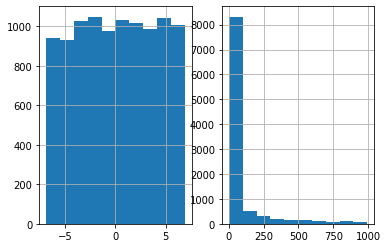

In [ ]:
## Snippet 9.4: The logUniform_gen Class

import numpy as np, pandas as pd, matplotlib.pyplot as mpl
from scipy.stats import rv_continuous, kstest

class logUniform_gen(rv_continuous):
  # random num log-uniform distribted between 1 and e.
  def _cdf(self, x):
    return np.log(x/self.a)/np.log(self.b/self.a)

def logUniform(a=1, b=np.exp(1)): return logUniform_gen(a=a, b=b, name='logUniform')

a,b, size= 1E-3, 1E3, 10000
vals = logUniform(a=a, b=b).rvs(size=size)

print(kstest(rvs = np.log(vals), cdf= 'uniform', args=(np.log(a), np.log(b/a)), N=size))
print(pd.Series(vals).describe())

mpl.subplot(1,2,1)
pd.Series(np.log(vals)).hist()
mpl.subplot(122)
pd.Series(vals).hist()
mpl.show()


In [ ]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web
ds = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start='1990-08-30')


In [ ]:
ds.keys()

dict_keys([0, 'DESCR'])

In [ ]:
print(ds['DESCR'])
print(ds[0].head())

F-F Research Data Factors daily
-------------------------------

This file was created by CMPT_ME_BEME_RETS_DAILY using the 202103 CRSP database. The Tbill return is the simple daily rate that, over the number of trading days in the month, compounds to 1-month TBill rate from Ibbotson and Associates Inc. Copyright 2021 Kenneth R. French

  0 : (7705 rows x 4 cols)
            Mkt-RF   SMB   HML     RF
Date                                 
1990-08-30   -1.39  0.93  0.35  0.028
1990-08-31    0.95 -0.77 -0.22  0.028
1990-09-04    0.09 -0.28 -0.28  0.031
1990-09-05    0.35  0.18 -0.15  0.031
1990-09-06   -1.06  0.45  0.60  0.031


In [ ]:
data = ds[0]
data = data.dropna()
data = data/100 #convert to percent returns
RF_data = (1+data['RF']).cumprod()